In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import librosa
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
from torch.utils.data import Dataset

import fastai.basics as fai
import fastai.vision as fv
import fastai.fastai_audio as fa

import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
path_good   = Path("Clean_test/")
path_crappy = Path("Noise_test/")
path        = Path("./")

In [4]:
def file_name(path:Path):
    file_name = path.relative_to(path_crappy)
    file_name = path_good/file_name
    return file_name.with_suffix(".wav")

def load_data(time, batch_size, amount=3., n_fft=512, n_mels=64):
    tfms = fa.get_cut_clip_transforms(time)+fa.get_frequency_batch_transforms(n_fft=n_fft, n_mels=n_mels)
    data = (fa.AudioAudioList.from_folder(path_crappy)
            .filter_by_rand(amount)
            .split_by_rand_pct(0.3)
            .label_from_func(file_name)
            .databunch(bs=batch_size, tfms=tfms))
    return data

In [5]:
def l1_loss_flat(a,b):
    return F.l1_loss_flat(a.squeeze(), b.squeeze())

In [6]:
def create_learner(data):
    return fv.unet_learner(data, fv.models.resnet34, 
                           blur=True, norm_type=fai.NormType.Weight, 
                           self_attention=True, y_range=(-3.,3.), 
                           loss_func=l1_loss_flat, wd=1e-2)

In [7]:
data = load_data(178, 8, 1)
learn = create_learner(data)

/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/basic_data.py:269: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([231936]), torch.Size([66560]), torch.Size([82432]), torch.Size([238592]), torch.Size([96768]), torch.Size([97280]), torch.Size([168960]), torch.Size([83968])], [torch.Size([231936]), torch.Size([66560]), torch.Size([82432]), torch.Size([238592]), torch.Size([96768]), torch.Size([97280]), torch.Size([168960]), torch.Size([83968])]]
  warn(message)


You can deactivate this warning by passing `no_check=True`.


In [8]:
data;

In [9]:
iteration = 'A'
def save_model(img_size, suffix=""):
    path = Path(f'models/{iteration}')
    path.mkdir(exist_ok=True)
    torch.save(learn.model.state_dict(), path/f'{img_size}-{suffix}.pth')
def load_model(img_size, suffix=""):
    learn.model.load_state_dict(torch.load(f'models/{iteration}/{img_size}-{suffix}.pth'))

In [11]:
learn.lr_find(); learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Traceback (most recent call last):
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/torch_core.py", line 127, in data_collate
    return torch.utils.data.dataloader.default_collate(to_data(batch))
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 232, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/holydemon/.anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 209, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 66560 and 172032 in dimension 1 at /opt/conda/conda-bld/pytorch_1549630534704/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307


In [12]:
gc.collect()

0

In [13]:
learn.fit_one_cycle(8, max_lr = 3e-3)

epoch,train_loss,valid_loss
1,0.437511,0.427555
2,0.416020,0.398375
3,0.382161,0.372205
4,0.348268,0.338596
5,0.342205,0.331767
6,0.321954,0.318121
7,0.302203,0.310284
8,0.292170,0.308910


In [14]:
learn.save('stage-1_loss-30')

In [ ]:
#learn.load('stage-1_loss-30')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07


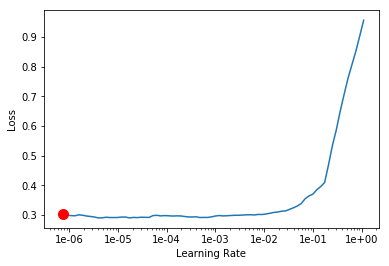

In [15]:
learn.lr_find(); learn.recorder.plot()

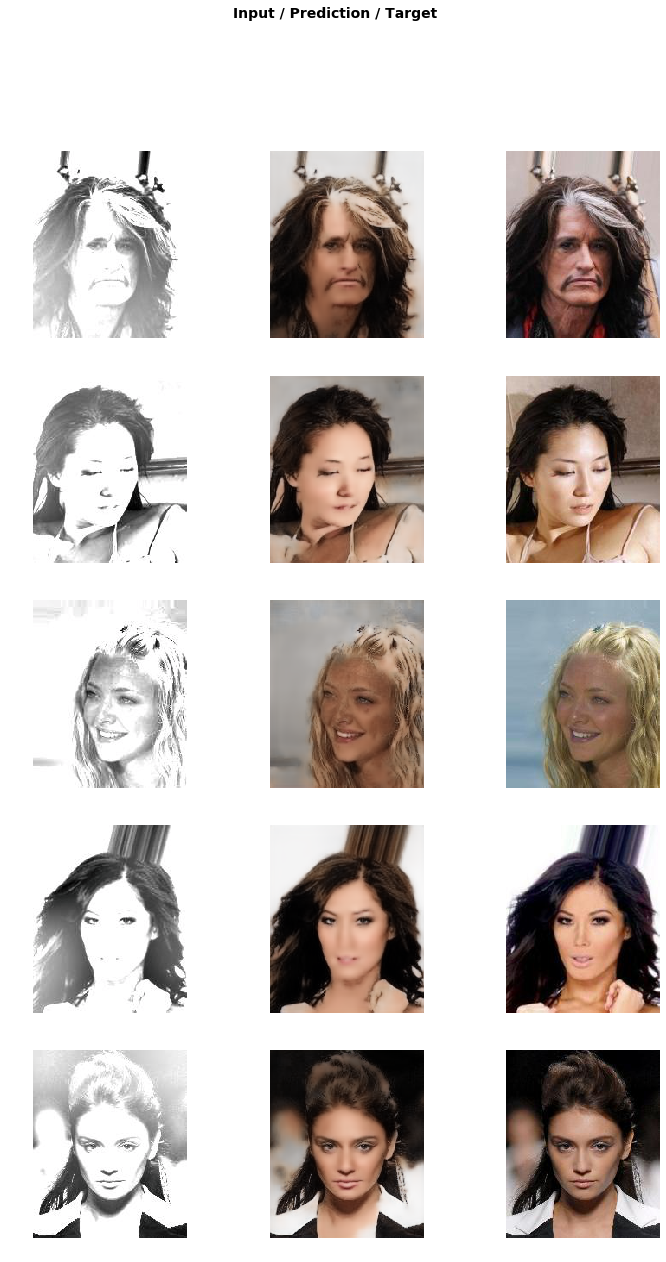

In [16]:
learn.show_results(3)

In [18]:
sizes = [96,128,160,178]
AS = {96:0.15, 128:0.2, 160:0.2, 178:0.3}
BS = {96:24, 128:16, 160:8, 178:4}

for size in sizes:
    lr = 2e-4
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,freeze) 
        lr *= 0.8

96 at freeze level 1


epoch,train_loss,valid_loss
1,0.293673,0.300742


96 at freeze level 2


epoch,train_loss,valid_loss
1,0.297138,0.291518


96 at freeze level 3


epoch,train_loss,valid_loss
1,0.296333,0.294291


128 at freeze level 1


epoch,train_loss,valid_loss
1,0.293776,0.290672


128 at freeze level 2


epoch,train_loss,valid_loss
1,0.299857,0.297444


128 at freeze level 3


epoch,train_loss,valid_loss
1,0.298242,0.292840


160 at freeze level 1


epoch,train_loss,valid_loss
1,0.296606,0.292055


160 at freeze level 2


epoch,train_loss,valid_loss
1,0.302329,0.293517


160 at freeze level 3


epoch,train_loss,valid_loss
1,0.296034,0.286956


178 at freeze level 1


epoch,train_loss,valid_loss
1,0.302743,0.287636


178 at freeze level 2


epoch,train_loss,valid_loss
1,0.319539,0.294428


178 at freeze level 3


epoch,train_loss,valid_loss
1,0.312585,0.299392


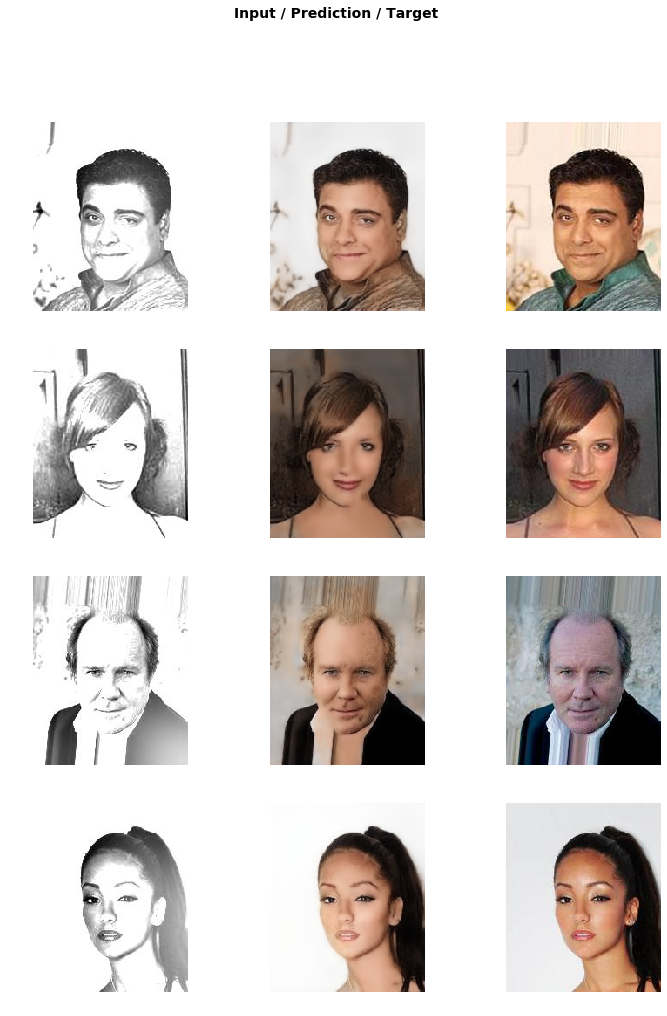

In [19]:
learn.show_results(rows=4)

In [33]:
vgg = torchvision.models.vgg16_bn(pretrained=True).eval()
fai.requires_grad(vgg, False)

In [34]:
good_blocks = [i-1 for i,o in enumerate(vgg.children()) if isinstance(o,nn.MaxPool2d)]

In [37]:
good_blocks[2:]

[22, 32, 42]

In [35]:
from PerceptualLoss import *

In [42]:
learn.loss_func = PerceptualLoss(vgg, good_blocks[2:], weights = [5,12,2]).cuda()

In [43]:
learn.data = load_data(178, 8, 1)

In [44]:
sizes = [96,128,160,178]
AS = {96:0.2, 128:0.3, 160:0.4, 178:0.5}
BS = {96:24, 128:16, 160:8, 178:4}

for size in sizes:
    lr = 1e-3
    for freeze in range(1, len(learn.layer_groups)+1):
        learn.data = load_data(size, BS[size], AS[size])
        learn.freeze_to(-freeze)
        print(f"{size} at freeze level {freeze}")
        gc.collect()
        torch.cuda.empty_cache()
        learn.fit_one_cycle(1, max_lr=slice(lr/64,lr))
        save_model(size,f'perceptual-{freeze+1}') 
        lr *= 0.8


96 at freeze level 1


epoch,train_loss,valid_loss
1,0.753825,0.749592


96 at freeze level 2


epoch,train_loss,valid_loss
1,0.751436,0.738061


96 at freeze level 3


epoch,train_loss,valid_loss
1,0.740495,0.733942


128 at freeze level 1


epoch,train_loss,valid_loss
1,0.731269,0.725458


128 at freeze level 2


epoch,train_loss,valid_loss
1,0.734427,0.726838


128 at freeze level 3


epoch,train_loss,valid_loss
1,0.730139,0.728302


160 at freeze level 1


epoch,train_loss,valid_loss
1,0.725440,0.719425


160 at freeze level 2


epoch,train_loss,valid_loss
1,0.725595,0.723693


160 at freeze level 3


epoch,train_loss,valid_loss
1,0.721992,0.718873


178 at freeze level 1


epoch,train_loss,valid_loss
1,0.726897,0.710370


178 at freeze level 2


epoch,train_loss,valid_loss
1,0.715281,0.718453


178 at freeze level 3


epoch,train_loss,valid_loss
1,0.727707,0.713520


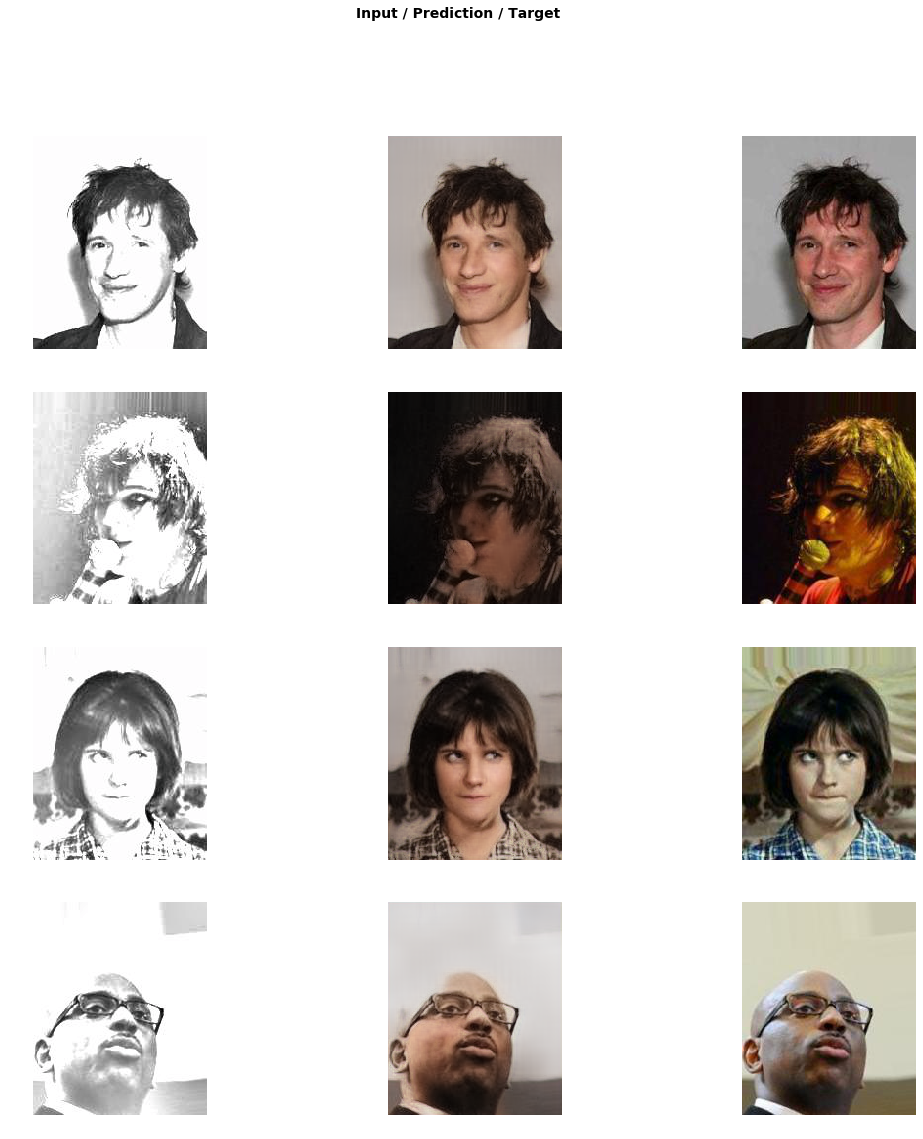

In [45]:
learn.show_results(rows=4,figsize=(18,18))

In [46]:
gc.collect()
torch.cuda.empty_cache()

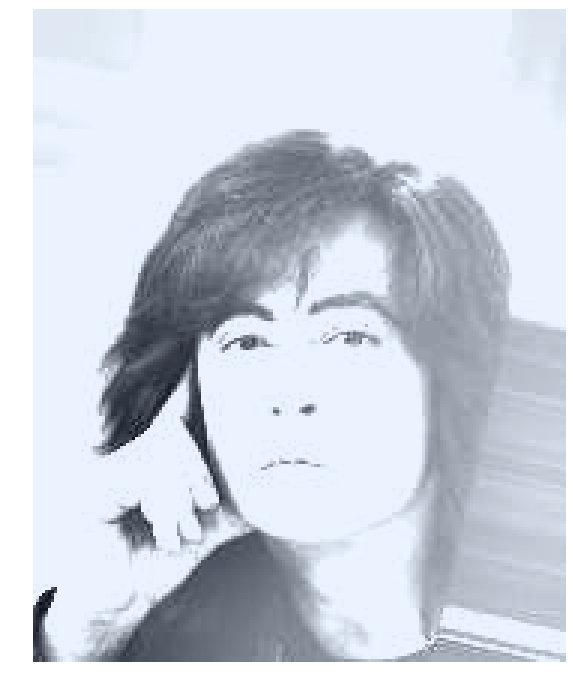

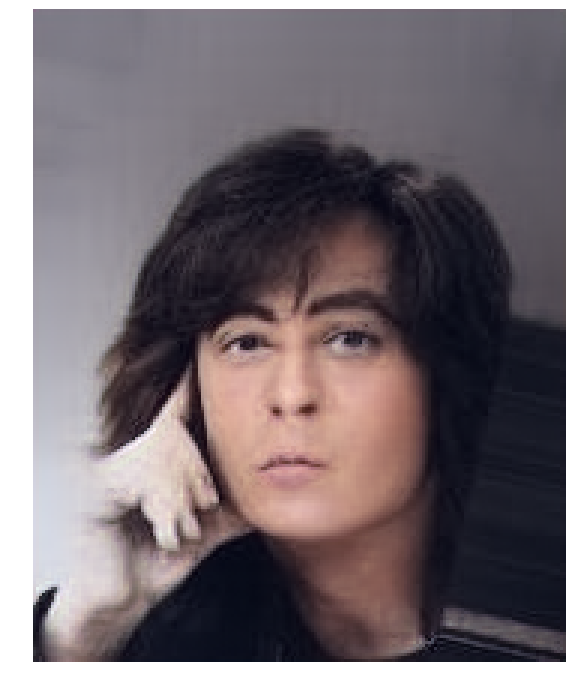

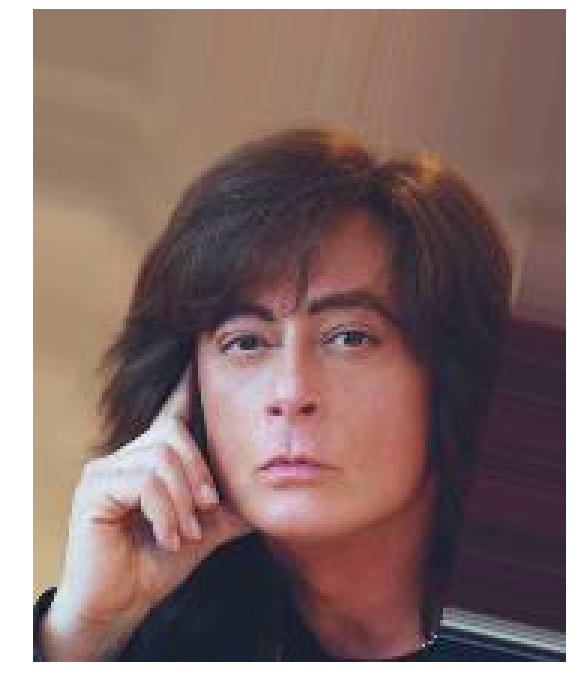

In [47]:
compare_manually()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06


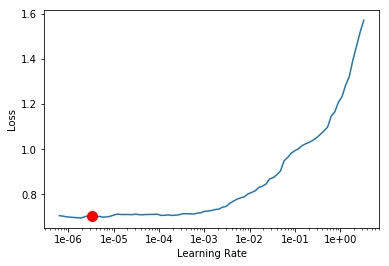

In [48]:
learn.lr_find(); learn.recorder.plot()

In [49]:
num_cycles = 3
for cycle in range(num_cycles):
    gc.collect()
    learn.data = load_data(178, 8, 1)
    learn.fit_one_cycle(1,slice(2e-4,3e-3),pct_start=0.8)
    save_model(178,f'shippuden-{cycle}')

epoch,train_loss,valid_loss
1,0.752864,0.745563


epoch,train_loss,valid_loss
1,0.726462,0.728711


epoch,train_loss,valid_loss
1,0.734947,0.720650


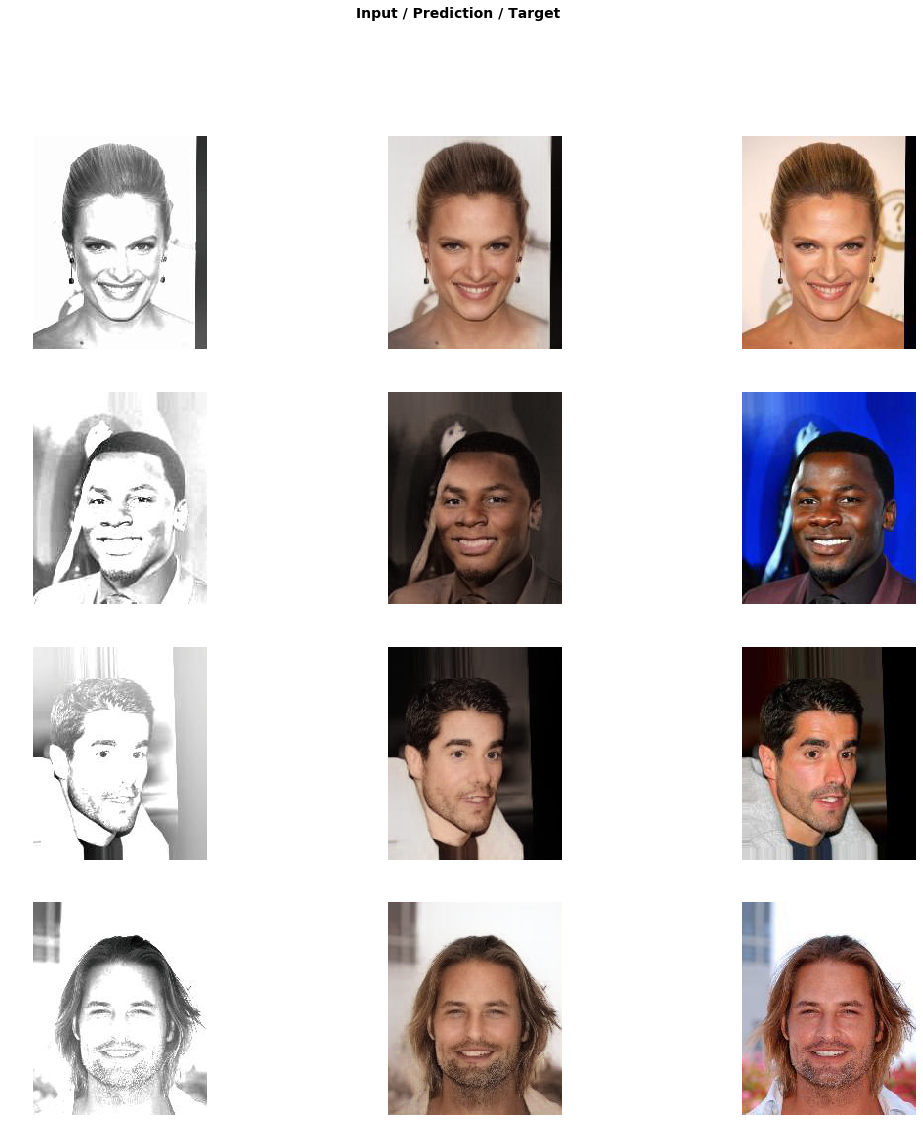

In [50]:
learn.show_results(rows=4,figsize=(18,18))